<a href="https://colab.research.google.com/github/OswaldVc/AnaDat/blob/main/Retratos_humanos.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

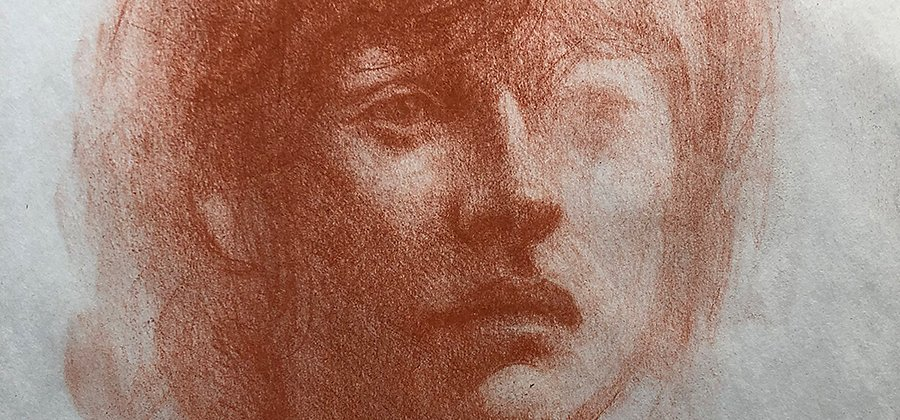

## **Usa IA para dibujar retratos humanos**
>> Néstor O. Vásquez C.

<p align="justify">
Piensa por un momento que eres un gran científico de datos, contratado por una organización sin fines de lucro y que recientemente inició una campaña para ayudar a las personas con discapacidad a aumentar la confianza en sí mismas. Como parte de la campaña, la organización regalará a las personas retratos de sí mismas. Debido a la gran popularidad de la campaña, sería muy costoso contratar a muchos artistas para dibujar estos retratos. Por lo tanto, tu trabajo consiste en utilizar inteligencia artificial para automatizar el dibujo de retratos humanos.
</p>

<p align="justify">
En este documento aprenderá cómo funciona la famosa aplicación Portrait Drawing y creará su propia herramienta de dibujo de retratos, estudiando la arquitectura del modelo U-squared Net de última generación. Eche un vistazo al resultado del modelo a continuación. ¡Te brinda los mismos resultados que obtendrías con la aplicación!
</p>

>>**Objetivos**

  - Comprender el uso y configuración de bloques en U-blocks.
  - Código de bloques en U-blocks con diferentes profundidades en PyTorch
  - Describir la arquitectura de U2-Net.
  - Construir arquitectura U2-Net utilizando bloques en U-blocks
  - Producir mapas de probabilidad de prominencia de una imagen de entrada como salidas laterales de U2-Net
  - Crear objeto PyTorch Dataset y PyTorch DataLoader
  - Cargue los pesos previamente entrenados de un U2-Net para realizar inferencias.


  >> **Bibliotecas necesarias**

  - Sklearn para aprendizaje automático y funciones relacionadas con analizaciones de aprendizaje automático.
  - Pandas para gestionar los datos.
  - Numpy para operaciones matemáticas.
  - Seaborn para visualizar los datos.
  - Matplotlib para herramientas de trazado adicionales.



In [ ]:
%%capture
!pip install skillsnetwork

In [ ]:
## Le recomendamos importar todas las bibliotecas requeridas en un solo lugar (aquí):
## Función para controlar los warnings
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn
warnings.filterwarnings('ignore')

## Bloque de librerias necesarias para el proyecto
import skillsnetwork
import numpy as np
import pandas as pd
from PIL import Image

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import os
import numpy as np
from skimage import io, transform
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms, utils
from torch.autograd import Variable

from torch.utils.data import Dataset, DataLoader

## Configuración de aspectos estéticos de los gráficos generados por Seaborn
sns.set_context('notebook')
sns.set_style('white')

>> Definición de funciones auxiliares

In [ ]:
def f(modules_dict, x):

    """
    Esta función recibe un OrderedDict que contiene todos los módulos de un bloque RSU definido y una entrada x,
    y devuelve el resultado del paso hacia adelante de los módulos.

    """
    inner_enc_layers = []  # Lista para almacenar las capas de codificación interna
    inner_dec_layers = []  # Lista para almacenar las capas de decodificación interna
    for layer_name, layer in modules_dict.items():
        if layer_name[-1] == 'd':  # Comprueba si el nombre de la capa termina con 'd'
            inner_dec_layers.append(layer)  # Si termina en 'd', se agrega a las capas de decodificación interna
        else:
            inner_enc_layers.append(layer)  # De lo contrario, se agrega a las capas de codificación interna

    hx = x  # Asigna la entrada x a hx
    hxin = inner_enc_layers[0](hx)  # Realiza el paso hacia adelante de la primera capa de codificación interna con la entrada x
    hx = hxin  # Actualiza hx con el resultado de la primera capa de codificación interna
    inner_enc_outputs = []  # Lista para almacenar las salidas de las capas de codificación interna

    # Bloque interno de codificación
    for layer in inner_enc_layers[1:]:
        hx = layer(hx)  # Realiza el paso hacia adelante de la capa actual de codificación interna con hx
        if not isinstance(layer, torch.nn.modules.pooling.MaxPool2d):
            inner_enc_outputs.append(hx)  # Si la capa no es una capa de agrupación máxima, agrega su salida a inner_enc_outputs

    # Bloque interno de decodificación + función residual
    hxd = inner_dec_layers[0](torch.cat((inner_enc_outputs.pop(), inner_enc_outputs.pop()),1))
    # Realiza el paso hacia adelante de la primera capa de decodificación interna con la concatenación de las dos últimas salidas de codificación
    for layer in inner_dec_layers[1:]:
        hxdup = _upsample_like(hxd, inner_enc_outputs[-1])
        # Realiza el paso hacia adelante de la capa actual de decodificación interna con la concatenación de la salida redimensionada y la salida de codificación actual
        hxd = layer(torch.cat((hxdup, inner_enc_outputs.pop()),1))

    return hxd + hxin  # Devuelve la suma de la salida de decodificación interna y la salida de codificación interna inicial


In [ ]:
def normPRED(d):

    """
    Esta función normaliza una predicción.

    """

    ma = torch.max(d)  # Encuentra el valor máximo en el tensor d
    mi = torch.min(d)  # Encuentra el valor mínimo en el tensor d

    dn = (d-mi)/(ma-mi)  # Normaliza los valores en el tensor d utilizando la fórmula de normalización

    return dn  # Devuelve el tensor normalizado


La siguiente celda define las clases RescaleT y ToTensor, que serán útiles para la transformación de datos tensoriales en una sección posterior de este proyecto.

In [ ]:
class RescaleT(object):
    def __init__(self, output_size):
        """
        Inicializa la clase RescaleT con el tamaño de salida deseado.

        Args:
            output_size (int): Tamaño de salida deseado para la imagen (ancho y alto).
        """
        self.output_size = output_size

    def __call__(self, sample):
        """
        Redimensiona la imagen de la muestra al tamaño de salida especificado.

        Args:
            sample (dict): Diccionario que contiene la información de la muestra, con las claves 'imidx' y 'image'.

        Returns:
            dict: Diccionario con la información de la muestra actualizada, con la imagen redimensionada.
        """
        imidx, image = sample['imidx'], sample['image']
        img = transform.resize(image, (self.output_size, self.output_size), mode='constant')

        return {'imidx':imidx, 'image':img}


class ToTensor(object):
    def __init__(self, flag=0):
        """
        Inicializa la clase ToTensor.

        Args:
            flag (int, optional): Bandera opcional. Por defecto, es 0.
        """
        self.flag = flag

    def __call__(self, sample):
        """
        Convierte la imagen de la muestra a un tensor y realiza la normalización.

        Args:
            sample (dict): Diccionario que contiene la información de la muestra, con las claves 'imidx' y 'image'.

        Returns:
            dict: Diccionario con la información de la muestra actualizada, con la imagen convertida a tensor.
        """
        imidx, image = sample['imidx'], sample['image']
        tmpImg = np.zeros((image.shape[0], image.shape[1], 3))
        image = image/np.max(image)

        tmpImg[:,:,0] = (image[:,:,0]-0.485)/0.229  # Normalización del canal rojo
        tmpImg[:,:,1] = (image[:,:,1]-0.456)/0.224  # Normalización del canal verde
        tmpImg[:,:,2] = (image[:,:,2]-0.406)/0.225  # Normalización del canal azul

        tmpImg = tmpImg.transpose((2,0,1))  # Transpone las dimensiones para que coincidan con el formato del tensor

        return {'imidx':torch.from_numpy(imidx), 'image':torch.from_numpy(tmpImg)}

>>**Fondo (opcional)**

<p align="justify">
Segmentar los objetos visualmente más atractivos de una imagen determinada ha sido una de las tareas más conocidas en el campo de la visión por ordenador. Tiene amplias aplicaciones en muchos campos, como el seguimiento visual y la segmentación de imágenes. Es posible que haya visto o jugado con codificadores automáticos u otros modelos de aprendizaje profundo como Deeplab para la segmentación semántica. A continuación se muestra una ilustración de la segmentación de imágenes:
<p/>

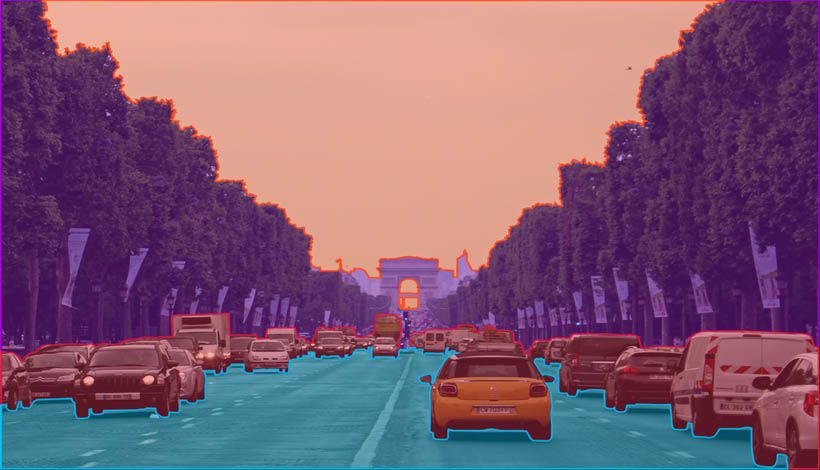

*Segmentación semántica de imágenes. imagen creditos: BIG DATA STUDIO*

<p align="justify">
En el océano de todos los modelos de aprendizaje profundo, hay un nombre que aún permanece en la cima: se llama U-Net. U-Net se lanzó en 2018 y desde entonces ha ganado gran popularidad por resolver varias tareas diferentes relacionadas con la segmentación. A continuación se muestra un diagrama que muestra la arquitectura de U-Net.
 <p/>

<center><img src="https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IND-GPXX0JV6EN/images/u-net-architecture.png" width="65%"></center>



<p style="color:gray; text-align:center;">Imagen, creditos: <a href="https://lmb.informatik.uni-freiburg.de/people/ronneber/u-net/?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkGuidedProjectsINDGPXX0JV6EN1119-2022-01-01">Olaf Ronneberger et al.</a></p>

Ten en cuenta que la tarea de detectar el objeto más importante o principal en una imagen determinada también se denomina "Detección de Objetos Salientes" o SOD. Con el desarrollo de redes neuronales convolucionales (CNN) profundas, SOD ha mejorado significativamente.

>> **¿Qué falta?**
<p align="justify">
Un patrón común en el diseño de la mayoría de las redes SOD es que se centran en el uso de características profundas extraídas de arquitecturas de modelos existentes, como VGG, ResNet, DenseNet, etc. Sin embargo, estas arquitecturas fueron originalmente diseñadas y entrenadas para la clasificación de imágenes, lo que no es adecuado para tareas SOD que requieren detalles locales e información de contraste global.
<p/>

<p align="justify">
Antes de sumergirnos en las aplicaciones de U2-Net, veamos primero sus desarrollos clave:
<p/>


>>Puede capturar más información contextual, tanto local como globalmente, desde diferentes escalas gracias a la combinación de campos receptivos de diferentes tamaños en los bloques U residuales (RSU) propuestos.
<p/>

>>Aumenta la profundidad de la arquitectura mientras mantiene mapas de características de alta resolución con un bajo costo de memoria y cálculo, debido a las convoluciones dilatadas y las operaciones de agrupación en los bloques RSU.

## **¿En qué consiste un bloque RSU?**

- Una capa de convolución de entrada, que transforma el mapa de características de entrada 𝑥

- (𝐻×𝑊×𝐶𝑖𝑛) a una aplicación intermedia 𝐹1(𝑥) con el canal de 𝐶𝑜𝑢𝑡

- Esta es una capa convolucional simple para la extracción de características locales.

- Una estructura de codificador-decodificador simétrica tipo U-Net con una altura de 𝐿 que toma el mapa de características intermedias 𝐹1(𝑥) como entrada y aprende a extraer y codificar la información contextual de múltiples escalas 𝑈(𝐹1(𝑥)). Un 𝐿 más grande conduce a un bloque U residual (RSU) más profundo, más operaciones de agrupación, una gama más amplia de campos recepvos y características locales y globales más ricas. Configurando 𝐿

<p align="justify">
permite la extracción de características de múltiples escalas a partir de mapas de características de entrada con resoluciones espaciales arbitrarias. Las características de múltiples escalas se extraen de mapas de características gradualmente reducidos y se codifican en mapas de características de alta resolución mediante aumento de muestreo, concatenación y convolución progresiva. Este proceso mitiga la pérdida de detalles finos causada por el muestreo directo a grandes escalas.
<p/>

- Una conexión residual que fusiona características locales y características de múltiples escalas mediante la suma 𝐹1(𝑥)+𝑈(𝐹1(𝑥))


El siguiente diagrama ilustra la estructura de un bloque RSU con $L=7$, donde:

- El cuadro verde representa a _Convolution+BatchNorm+ReLU_ layer;

- El cuadro azul representa a **downsampling** _Convolution+BatchNorm+ReLU_ layer;

- El cuadro rosa representa un  **upsampling** _Convolution+BatchNorm+ReLU_ layer.


<center><img src="https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IND-GPXX0JV6EN/images/RSU.png" width="40%"></center>


<p style="color:gray; text-align:center;">Imágen creditos: <a href="https://github.com/xuebinqin/U-2-Net">Xuebin Qin et al.</a></p>

Hasta aquí basta de explicaciones, ya me dio sueño!! Hágamos lo que nos apasiona, programemos, vamos...

## **Bloques RSU**


>> Como vio, un solo bloque RSU consta de muchas capas Convolución+BatchNorm+ReLU. Podemos crear una clase llamada REBNCONV que agrupe las capas de activación Convolution, BatchNorm y ReLU, de modo que estas capas se puedan agregar a nuestro bloque RSU de manera más fácil y clara.

In [ ]:
class REBNCONV(nn.Module):
    def __init__(self, in_ch=3, out_ch=3, dirate=1):
        """
        Inicializa la capa REBNCONV.

        Args:
            in_ch (int, optional): Número de canales de entrada. Por defecto, es 3.
            out_ch (int, optional): Número de canales de salida. Por defecto, es 3.
            dirate (int, optional): Tasa de dilatación. Por defecto, es 1.
        """
        super(REBNCONV, self).__init__()

        # Capa de convolución
        self.conv_s1 = nn.Conv2d(in_ch, out_ch, 3, padding=1*dirate, dilation=1*dirate)

        # Capa de normalización por lotes
        self.bn_s1 = nn.BatchNorm2d(out_ch)

        # Función de activación ReLU
        self.relu_s1 = nn.ReLU(inplace=True)


    def forward(self, x):
        """
        Realiza el paso hacia adelante de la capa REBNCONV.

        Args:
            x (tensor): Tensor de entrada.

        Returns:
            tensor: Tensor resultante después de aplicar la convolución, la normalización y la ReLU.
        """
        hx = x  # Asigna el tensor de entrada a hx

        # Realiza la convolución, la normalización por lotes y la ReLU en secuencia
        return self.relu_s1(self.bn_s1(self.conv_s1(hx)))

>> A continuación, definimos una función _upsample_like que aumenta la muestra de src para que src tenga la misma forma que tar. Esto nos ayudará con nuestra concatenación de salidas de diferentes formas más adelante.

In [ ]:
def _upsample_like(src, tar):
    """
    Realiza un muestreo ascendente (upsampling) en src para que tenga las mismas dimensiones que tar.

    Args:
        src (tensor): Tensor de entrada que se va a muestrear ascendente.
        tar (tensor): Tensor de destino con el tamaño al que se desea muestrear ascendente src.

    Returns:
        tensor: Tensor resultante después de realizar el muestreo ascendente en src para que tenga las mismas dimensiones que tar.
    """
    # Realiza el muestreo ascendente (upsampling) en src para que tenga las mismas dimensiones que tar
    src = F.upsample(src, size=tar.shape[2:], mode='bilinear')
    return src

¡Con estos dos ayudantes, comencemos a crear los bloques RSU!
<p align="justify">
Crearemos varios bloques RSU con diferentes profundidades. Todos ellos serán necesarios para construir nuestra arquitectura U2-Net. Para mapas de características con gran altura y ancho, necesitamos mayor 𝐿 para capturar más información a gran escala. He simplificado las funciones directas de todos los bloques RSU usando la función auxiliar f. Si está interesado en saber en detalle cómo se reenvían las salidas de la capa en los bloques RSU, no dude en consultar el código en la sección Definición de funciones auxiliares.
<p/">

>> **RSU-7**

Un bloque RSU-7 tiene una profundidad (𝐿) de 7. Consta de:

- Una capa REBNCONV de entrada.

- Siete capas REBNCONV de reducción de resolución, cada una seguida de una capa MaxPooling excepto rebnconv6 y rebnconv7 (para evitar que la resolución de las dos últimas capas sea demasiado baja);

- seis capas REBNCONV de muestreo mejorado, cada una toma como entrada la concatenación de los mapas de características muestreados de su capa anterior y los de su capa de muestreo mejorado simétrico.



In [ ]:
class RSU7(nn.Module):
    def __init__(self, in_ch=3, mid_ch=12, out_ch=3):
        """
        Inicializa la red RSU7.

        Args:
            in_ch (int, optional): Número de canales de entrada. Por defecto, es 3.
            mid_ch (int, optional): Número de canales de las capas intermedias. Por defecto, es 12.
            out_ch (int, optional): Número de canales de salida. Por defecto, es 3.
        """
        super(RSU7,self).__init__()

        # Capas de convolución y normalización para la entrada
        self.rebnconvin = REBNCONV(in_ch,out_ch,dirate=1)

        # Capas de convolución y normalización para las capas intermedias
        self.rebnconv1 = REBNCONV(out_ch,mid_ch,dirate=1)
        self.pool1 = nn.MaxPool2d(2,stride=2,ceil_mode=True)

        self.rebnconv2 = REBNCONV(mid_ch,mid_ch,dirate=1)
        self.pool2 = nn.MaxPool2d(2,stride=2,ceil_mode=True)

        self.rebnconv3 = REBNCONV(mid_ch,mid_ch,dirate=1)
        self.pool3 = nn.MaxPool2d(2,stride=2,ceil_mode=True)

        self.rebnconv4 = REBNCONV(mid_ch,mid_ch,dirate=1)
        self.pool4 = nn.MaxPool2d(2,stride=2,ceil_mode=True)

        self.rebnconv5 = REBNCONV(mid_ch,mid_ch,dirate=1)
        self.pool5 = nn.MaxPool2d(2,stride=2,ceil_mode=True)

        self.rebnconv6 = REBNCONV(mid_ch,mid_ch,dirate=1)

        self.rebnconv7 = REBNCONV(mid_ch,mid_ch,dirate=2)

        # Capas de convolución y normalización para las capas intermedias (descendentes)
        self.rebnconv6d = REBNCONV(mid_ch*2,mid_ch,dirate=1)
        self.rebnconv5d = REBNCONV(mid_ch*2,mid_ch,dirate=1)
        self.rebnconv4d = REBNCONV(mid_ch*2,mid_ch,dirate=1)
        self.rebnconv3d = REBNCONV(mid_ch*2,mid_ch,dirate=1)
        self.rebnconv2d = REBNCONV(mid_ch*2,mid_ch,dirate=1)
        self.rebnconv1d = REBNCONV(mid_ch*2,out_ch,dirate=1)

    def forward(self,x):
        """
        Realiza el paso hacia adelante de la red RSU7.

        Args:
            x (tensor): Tensor de entrada.

        Returns:
            tensor: Tensor resultante después de pasar por la red RSU7.
        """
        # Obtiene el diccionario de módulos de la red
        modules_dict = self.__dict__['_modules']
        # Llama a la función f para realizar el paso hacia adelante a través de los módulos de la red
        result = f(modules_dict, x)
        return result

### **RSU-6**

Un bloque RSU-6 tiene profundidad (𝐿) Consiste en:

- Una capa REBNCONV de entrada.
- Seis capas REBNCONV de reducción de resolución, cada una seguida de una capa MaxPooling excepto rebnconv5 y rebnconv6 (para evitar que la resolución de las dos últimas capas sea demasiado baja).
- Cinco capas REBNCONV de muestreo mejorado, cada una toma como entrada la concatenación de los mapas de características muestreados de su capa anterior y los de su capa de muestreo mejorado simétrico.




In [ ]:
class RSU6(nn.Module):
    def __init__(self, in_ch=3, mid_ch=12, out_ch=3):
        """
        Inicializa la red RSU6.

        Args:
            in_ch (int, optional): Número de canales de entrada. Por defecto, es 3.
            mid_ch (int, optional): Número de canales de las capas intermedias. Por defecto, es 12.
            out_ch (int, optional): Número de canales de salida. Por defecto, es 3.
        """
        super(RSU6,self).__init__()

        # Capas de convolución y normalización para la entrada
        self.rebnconvin = REBNCONV(in_ch,out_ch,dirate=1)

        # Capas de convolución y normalización para las capas intermedias
        self.rebnconv1 = REBNCONV(out_ch,mid_ch,dirate=1)
        self.pool1 = nn.MaxPool2d(2,stride=2,ceil_mode=True)

        self.rebnconv2 = REBNCONV(mid_ch,mid_ch,dirate=1)
        self.pool2 = nn.MaxPool2d(2,stride=2,ceil_mode=True)

        self.rebnconv3 = REBNCONV(mid_ch,mid_ch,dirate=1)
        self.pool3 = nn.MaxPool2d(2,stride=2,ceil_mode=True)

        self.rebnconv4 = REBNCONV(mid_ch,mid_ch,dirate=1)
        self.pool4 = nn.MaxPool2d(2,stride=2,ceil_mode=True)

        self.rebnconv5 = REBNCONV(mid_ch,mid_ch,dirate=1)

        self.rebnconv6 = REBNCONV(mid_ch,mid_ch,dirate=2)

        # Capas de convolución y normalización para las capas intermedias (descendentes)
        self.rebnconv5d = REBNCONV(mid_ch*2,mid_ch,dirate=1)
        self.rebnconv4d = REBNCONV(mid_ch*2,mid_ch,dirate=1)
        self.rebnconv3d = REBNCONV(mid_ch*2,mid_ch,dirate=1)
        self.rebnconv2d = REBNCONV(mid_ch*2,mid_ch,dirate=1)
        self.rebnconv1d = REBNCONV(mid_ch*2,out_ch,dirate=1)

    def forward(self,x):
        """
        Realiza el paso hacia adelante de la red RSU6.

        Args:
            x (tensor): Tensor de entrada.

        Returns:
            tensor: Tensor resultante después de pasar por la red RSU6.
        """
        # Obtiene el diccionario de módulos de la red
        modules_dict = self.__dict__['_modules']
        # Llama a la función f para realizar el paso hacia adelante a través de los módulos de la red
        result = f(modules_dict, x)
        return result